In [1]:
push!(LOAD_PATH, "./")
using PyPlot
using BdgSolver

In [2]:
sh = Shape(1000, 1000, 10)
mat = Material("Sn", 148.0, 0.000618, 0.666)
pars = Parameters(mat, sh)
sys = System(mat, sh, pars)
H = Hamiltonian(mat, sh, pars);
BdgSolver.print_parameters(sys)

--------------------------------------------------------------------------------
--- Shape dimensions -----------------------------------------------------------
--------------------------------------------------------------------------------
Lx  =   1000.0 Bohr,   Ly  =   1000.0 Bohr,   Lz = 10.0 Bohr
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--- Material properties --------------------------------------------------------
--------------------------------------------------------------------------------
Carrier density:            ρ   = 148.0     Bohr^{-1},
Debye energy:               ħω  = 0.000618    Ry,
Electron phonon coupling:   λ   = 0.666
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--- Derived parameters  -----------------------------------------

## Integration

Clearly, integrating like this won't be compatible with being able to apply corrections as convolutions to the thermal weight or DOS. I simply can't do "symbolic" integrations for all the corrections and get a function as end result. I'll have to discretize at least part of it, on which I can apply the corrections. I think it's cleanest if I just apply *all* corrections to the DOS:

$$M_{ij} = \Phi_{ij} \int_{DW} d\xi\, N_i(\xi) \int d\Xi\, F(\xi - \Xi, \Gamma_\xi) \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}$$

If we put in the Debye-window cutoff manually as a characteristic function, $\chi_{DW}(\xi)$, both integrations become completely equivalent (at least in principle).

$$M_{ij} = \Phi_{ij} \int d\xi\, \chi_{DW}(\xi)N_i(\xi) \int d\Xi\, F(\xi - \Xi, \Gamma_\xi) \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}.$$

Reversing the integrations:
$$M_{ij} = \Phi_{ij} \int d\Xi\, \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}  \left\{\int d\xi\, F(\xi - \Xi, \Gamma_\xi) \chi_{DW}(\xi)N_i(\xi)\right\}.$$

This way, I can repeatedly keep applying corrections to the DOS. I think. Right?


Note that, if I choose to discretize the DOS, and apply all corrections at the DOS level, I will essentially be multiplying the number of operations (and memory usage) by a factor $\nu$... 

## Thermal determinant

The superconducting and non-superconducting regimes are demarcated by the condition

$$ \det\left(M_{ij} - \delta_{ij}\right) = 0, $$

where $M_{ij}$ is given by

$$M_{ij} = \frac{g}{4} \frac{1}{2\pi} \frac{2m}{\hbar^2} \Phi_{ij}
      \int_{DW}d\xi\, \theta(\xi - \epsilon_i) \frac{\tanh\left(\frac{\beta_c \xi}{2}\right)}{\xi}.$$
      
Seeing as how, for a 2D system, the density of states can be written as
$$N_i(\xi) = \frac{4\pi m}{\hbar^2} \theta(\xi - \epsilon_i), $$
we can rewrite this as
$$M_{ij} = \frac{g}{16\pi^2} \Phi_{ij}
      \int_{DW}d\xi\, N_i(\xi) \frac{\tanh\left(\frac{\beta_c \xi}{2}\right)}{\xi}.$$
      
**Ugh**, depending on who you ask, the DOS could also be 
$$N_i(\xi) = \frac{m}{\pi \hbar^2} \theta(\xi - \epsilon_i), $$
(that is, the previously stated one, divided by $4\pi^2$.

I'd better compare with the old Python code to make sure I don't miss any factors...


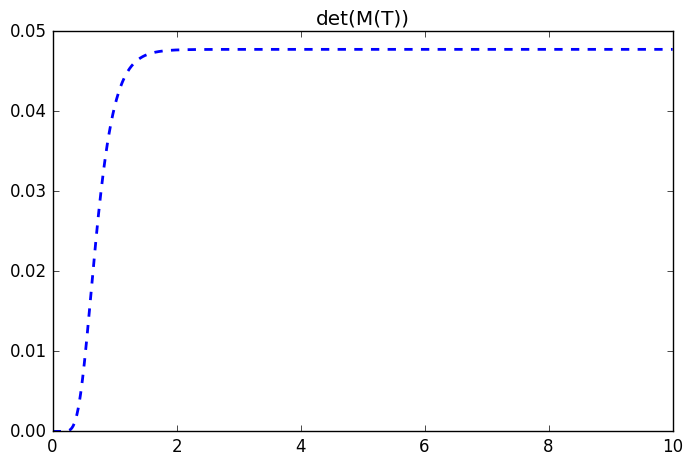

1.074842 seconds (914.72 k allocations: 28.329 MB, 2.29% gc time)


In [3]:
@time βs, Ds = BdgSolver.get_Tc(sys)
fig = figure("Thermal determinant",figsize=(8,5))
title("det(M(T))")
plot(βs, Ds, color="blue", linewidth=2.0, linestyle="--")
show()

# TODO:
* Make all the parameters realistic.
* Add missing factors everywhere (I'm thinking, in front of the thermal integral!)
* Add a - \delta_{ij} to the determinant
* Calculate $g$, add it to thermal integral
* Add prefactor to DOS
